## Texture vs Shape: introduction
(homework #2 for DNN 2024/25)

<div style="max-width: 60em">

In this homework, we will look at a modern residual convolutional net. While they perform very well on image classification tasks, some problems they commonly have are that:<br>
* they rely too much on small-scale features (textures) rather than large-scale ones (shape). This often generalizes poorly to unseen datasets and is less human-aligned (e.g. explanations of why a model chose this class may be less interpretable).
* they are very susceptible to adversarial images, i.e. inputs maliciously altered in a way that is imperceptible to humans and shouldn't change the classification, but completely fool the model, making it output high probabilities for unrelated classes.

While the two problems are somewhat related, we focus on the first one.
You are given a pre-trained model and datasets, as well as the code for standard evaluation and training loops, and for generating adversarial examples.
Your tasks (fully detailed in later cells) will be as follows:

0. Adapt a pretrained model to the smaller datasets by changing the classification layer.
1. Implement transformations (blur, pixelize, noise) that can help us elucidate and perhaps remedy the texture-bias problem.
2. Compare how the model handles them and how much they help as augmentations used in fine-tuning.
3. Read a paper about AdvProp: a relatively simple method for training models with less texture bias, using adversarial examples; implement and evaluate it.
4. Implement and evaluate SparseTopK: another, even simpler method proposed for the same problem: it just zeroes all but the top 20% activations in some layers.

Submission requirements:
* Please do not modify anything outside of the `### BEGIN SOLUTION ... ### END SOLUTION` blocks (if you feel it might be useful somewhere, ask on slack).
* Please make sure to submit your solution as a notebook with saved cell outputs.
* Don't use `tqdm.notebook` or `tqdm.auto`, just plain `tqdm`.
* It should be possible to execute the notebook from top to bottom when loaded in Colab with a GPU, in a reasonable amount of time.
* Plots should either be images embedded in cell outputs (in a way that shows correctly when loading the notebook from file, without executing it), or attached together with the exported .ipynb notebook in a .zip file  (screenshots are admissible, but prefer exporting with e.g. `plt.savefig()`).

</div>

## Imports

In [1]:
import json
import multiprocessing
from collections.abc import Callable, Iterable, Sequence
from copy import deepcopy
from functools import partial
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models
import torch.optim.lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

### BEGIN SOLUTION
# Feel free to add more imports and global settings here, though none are necessary.
### END SOLUTION

%matplotlib inline

multiprocessing.set_start_method("spawn", force=True)  # Needed when using CUDA.
torch.set_num_threads(8)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    torch.cuda.set_device(2)

_ = torch.manual_seed(42)

## Datasets

In [2]:
%%bash
# 219 MiB
if [ ! -d datasets ]; then
    gdown https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg \
        && tar -xf datasets.tar.gz \
        && rm datasets.tar.gz
fi

Downloading...
From (original): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg
From (redirected): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg&confirm=t&uuid=f0026397-cdce-4e65-89f4-68815fba490b
To: /content/datasets.tar.gz
100%|██████████| 229M/229M [00:01<00:00, 137MB/s]


##### MiniImageNet
MiniImageNet is a downscaled subset of ISVLRC ImageNet-1k<sup>[1]</sup> with only 10 classes (RGB, irregular sizes up to 256x256).
Train/val is a uniformly random split, the parts have 2000/100 images per class, respectively.

We will use the *train* part for fine-tuning and *val* for validation and various evaluation.

[1] https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview

['bear', 'bicycle', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'elephant', 'truck']


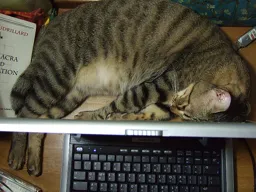

5 cat


In [3]:
MINI_IMAGENET_PATH = Path("datasets/miniImageNet")
SELECTED_CLASSES = ImageFolder(MINI_IMAGENET_PATH / "train").classes
assert SELECTED_CLASSES == ImageFolder(MINI_IMAGENET_PATH / "val").classes


def example() -> None:  # Note: we scope examples to avoid polluting the global namespace.
    print(SELECTED_CLASSES)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val")
    img, label = dataset[505]
    display(img)
    print(label, dataset.classes[label])


example()

##### eval_transform, display_image_tensor()

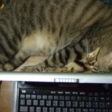

img.shape=torch.Size([3, 112, 112]), img.dtype=torch.float32, min..max=-2.015..2.64
label=5 (cat)


In [4]:
def get_eval_transform() -> v2.Compose:
    """
    The default transform used on all ImageNet images before passing to a model.

    (Typically papers end up with 224x224 images, we make them smaller for speed.)
    """
    return v2.Compose(
        [
            v2.PILToTensor(),
            v2.Resize(size=128, antialias=True),
            v2.CenterCrop(size=(112, 112)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ]
    )


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize an image tensor of shape (*B, C, H, W) from 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return (x - mean) / std


def unnormalize(x: torch.Tensor) -> torch.Tensor:
    """Revert an image tensor of shape (*B, C, H, W) to 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return x * std + mean


def display_image_tensor(x: torch.Tensor) -> None:
    """Display a normalized image tensor of shape (C, H, W) as a PIL Image."""
    pil_image: PIL.Image.Image = v2.ToPILImage()(unnormalize(x))
    display(pil_image)


def ceildiv(a: int, b: int) -> int:
    """Return ceil(a /b)."""
    return -(-a // b)


def example() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[505]
    display_image_tensor(img)
    print(f"{img.shape=}, {img.dtype=}, min..max={img.min().item():.4g}..{img.max().item():.4g}")
    print(f"{label=} ({dataset.classes[label]})")


example()

##### alt_test_dataset
This is a dataset with the same classes and some of the same images, but restylized or otherwise altered to mislead models reliant on textures.
We will use this dataset to test if a training method results in a model that is less reliant on textures.
Note that some alterations are pretty heavy, so the images look very different and it is difficult to achieve more than ~40-50% accuracy.

RGB, 224x224, 280 images per class.

(The dataset was created from https://github.com/bethgelab/model-vs-human/releases/tag/v0.1)

cue-conflict 800, edge 100, low-pass 800, silhouette 100, sketch 500, stylized 500, total 2800


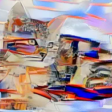

In [5]:
ALT_TEST_DATASET_PATHS = sorted(Path("datasets/testSets").iterdir())
alt_test_dataset = ConcatDataset([ImageFolder(p, transform=get_eval_transform()) for p in ALT_TEST_DATASET_PATHS])


def example() -> None:
    for p in ALT_TEST_DATASET_PATHS:
        dataset = ImageFolder(p, transform=get_eval_transform())
        assert dataset.classes == SELECTED_CLASSES
        print(p.name, len(dataset), end=", ")
        # display_image_tensor(dataset[int(len(dataset) * 0.53)][0])
    print("total", len(alt_test_dataset))

    img, _label = alt_test_dataset[445]
    display_image_tensor(img)


example()

## Evaluate() and get_dataloader()

Here's an implementation of an evaluation loop, to be used in this notebook.

In [6]:
def get_dataloader(
    dataset: Dataset,
    shuffle: bool = False,
    batch_size: int = 256,
    num_workers: int = 2,
    pin_memory: bool = True,
    prefetch_factor: int = 2,
    persistent_workers: bool = True,
    timeout: float = 30.0,
    **kwargs: Any,
) -> DataLoader:
    """DataLoader constructor with different defaults."""
    if num_workers == 0:
        pin_memory = False
        persistent_workers = False
        prefetch_factor = None
        timeout = 0.0

    return DataLoader(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers,
        timeout=timeout,
        **kwargs,
    )

In [7]:
def evaluate(
    model: torch.nn.Module,
    dataloader: Dataset | DataLoader,
    description: str = "eval",
    device: str = DEVICE,
    quiet: bool = False,
    use_workers: bool = True,
) -> float:
    """Evaluate a model on a dataset or dataloader, returning the accuracy (0..1)."""
    model = model.to(device).eval()
    if not isinstance(dataloader, DataLoader):  # Create from dataset.
        if use_workers:
            dataloader = get_dataloader(dataloader, persistent_workers=False)
        else:
            dataloader = get_dataloader(dataloader, num_workers=0)

    accuracy, n_done, n_correct = 0, 0, 0

    progress_bar = tqdm(dataloader, desc=description, disable=quiet, delay=0.5)
    with torch.no_grad(), progress_bar:
        for image_batch, label_batch in progress_bar:
            logits_batch = model(image_batch.to(device))
            predictions = logits_batch.argmax(dim=1)

            n_done += len(label_batch)
            n_correct += (predictions == label_batch.to(device)).sum().item()
            accuracy = n_correct / n_done if n_done else 0
            progress_bar.set_postfix({"accuracy": f"{accuracy * 100:.1f} %"})

    return accuracy

## Task 0: Model, remapping the classification layer

We will use a ready-made model pretrained on ImageNet-1k.<br>
Since they all output logits for 1000 classes (`IMAGENET_CATEGORIES`),<br>
we need to alter the classification layer to output logits for the 10 MiniImageNet classes instead (`SELECTED_CLASSES`).<br>
Note that several ImageNet-1k classes can map to the same MiniImageNet class.<br>

Your task is to complete the implementation of `remap_output_layer()` below,<br>
so that the model works without any fine-tuning/training of the last layer.<br>
In `example_remapping()` below (which evaluates the model on the val dataset),<br>
you should achieve at least 70% accuracy and finish in under 35 seconds on Colab CPU (~15s on GPU).<br>

In [8]:
SELECTED_MODEL = (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
# 5.3M params, 78% acc@1 on original ImageNet-1k

# Other models we considered, but cut for time:
# * (torchvision.models.mobilenet_v3_small, torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
#     2.5M params, 68% acc@1
# * (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
#     11.7M params, 70% acc@1 on original ImageNet-1k
# * (torchvision.models.efficientnet_v2_s, torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
#     21.5M params, 84% acc@1

IMAGENET_CATEGORIES = SELECTED_MODEL[1].meta["categories"]
assert IMAGENET_CATEGORIES == torchvision.models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
print(len(IMAGENET_CATEGORIES), ", ".join(IMAGENET_CATEGORIES[:7] + ["..."]))

1000 tench, goldfish, great white shark, tiger shark, hammerhead, electric ray, stingray, ...


In [9]:
# Some technical details, feel free to ignore.


def _load_imagenet_id_to_class_id_map(classes: Sequence[str] = SELECTED_CLASSES) -> dict[int, int]:
    """
    Return a map from imagenet ids 0..999 to selected class ids: 0..len(classes)-1.

    Classes should be a subset of the following 16 class names:
        airplane,bear,bicycle,bird,boat,bottle,car,cat,chair,clock,dog,elephant,keyboard,knife,oven,truck
    """
    imagenet_id_to_name = {i: name for i, name in enumerate(IMAGENET_CATEGORIES)}
    class_to_idx = {name: i for i, name in enumerate(classes)}
    with open("datasets/imagenet_name_to_synset_id.json") as f:
        name_to_synset = json.load(f)
    with open("datasets/synset_id_to_class.json") as f:
        synset_to_class = json.load(f)
    # Not all synsets defined in synset_id_to_class.json are present in ImageNet-1k
    # (they also don't appear in our dataset 10-class-ImageNet).
    imagenet_name_to_class_name = {
        name: synset_to_class[synset] for name, synset in name_to_synset.items() if synset in synset_to_class
    }

    result = dict[int, int]()
    for imagenet_id, imagenet_name in imagenet_id_to_name.items():
        # Not all imagenet names are present in 10-class-ImageNet, obviously.
        if imagenet_name in imagenet_name_to_class_name:
            class_name = imagenet_name_to_class_name[imagenet_name]
            # Not all class names defined for 16-class-ImageNet are present in our dataset 10-class-ImageNet.
            if class_name in class_to_idx:
                result[imagenet_id] = class_to_idx[class_name]

    for k, v in result.items():
        assert 0 <= k < len(IMAGENET_CATEGORIES) and 0 <= v < len(classes)

    return result


def _reset_model_weights(model: torch.nn.Module) -> None:
    """Reinitialize the model weights randomly. We probably won't use it."""
    # Some models define reset_parameters(), but unfortunately not all.
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d | torch.nn.GroupNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.Linear):
            init_range = 1.0 / np.sqrt(m.out_features)
            torch.nn.init.uniform_(m.weight, -init_range, init_range)  # EfficientNet v1
            # torch.nn.init.normal_(m.weight, 0, 0.01)  # MobileNet v3
            torch.nn.init.zeros_(m.bias)

In [10]:
def remap_output_layer(layer: torch.nn.Linear, id_map: dict[int, int]) -> torch.nn.Module:
    """Return a new final classification logit layer where the i-th class becomes id_map[i] instead."""
    assert layer.out_features == len(IMAGENET_CATEGORIES)
    ### BEGIN SOLUTION

    # number of classes in mini imagenet
    new_out = len(set(id_map.values()))

    # new layer that will replace last layer in net (with 10 out features instead of 1000)
    new_layer = torch.nn.Linear(
        in_features=layer.in_features,
        out_features=new_out,
        bias=True,
    )

    # we want to leave out only the nodes that represent some class in mini imagenet
    # this means the only important weights and biases (from old layer) are those pointing to keys of id_map
    with torch.no_grad():
        # zero out all weights and biases in new layer
        new_layer.weight.zero_()
        new_layer.bias.zero_()
        for old, new in id_map.items():
            # mapping weights and biases from old layer to new layer,
            # summing up those weights and biases that are pointing to the same value
            new_layer.weight[new] += layer.weight[old]
            new_layer.bias[new] += layer.bias[old]

    return new_layer
    ### END SOLUTION

In [11]:
def get_model(
    eval: bool = False, reset: bool = False, selected_classes: Sequence[str] = SELECTED_CLASSES
) -> torch.nn.Module:
    model_fn, model_weights = SELECTED_MODEL
    model = model_fn(weights=model_weights)

    # Find and replace the last Linear layer.
    id_map = _load_imagenet_id_to_class_id_map(selected_classes)
    last_linear_layer = None
    for parent_module in model.modules():
        for name, layer in parent_module.named_children():
            if isinstance(layer, torch.nn.Linear):
                last_linear_layer = (parent_module, name, layer)
    assert last_linear_layer is not None
    parent_module, name, layer = last_linear_layer

    setattr(parent_module, name, remap_output_layer(layer, id_map))

    if reset:
        _reset_model_weights(model)

    return model.eval() if eval else model.train()


get_model(eval=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 90.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:

def example_remapping() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    model = get_model(eval=True)
    evaluate(model, dataset)


example_remapping()

eval: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it, accuracy=87.2 %]


## Training

Here's an implementation of a training loop that we will use for this notebook.
You should not need to alter hyperparameters, use the defaults of `Trainer.__init__()`.

In [13]:
BATCH_NORM_TYPES = (
    torch.nn.BatchNorm1d
    | torch.nn.BatchNorm2d
    | torch.nn.BatchNorm3d
    | torch.nn.SyncBatchNorm
    | torch.nn.LazyBatchNorm1d
    | torch.nn.LazyBatchNorm2d
    | torch.nn.LazyBatchNorm3d
)


class Trainer:
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = DEVICE,
        extra_augmentation: v2.Transform | None = None,
        use_workers: bool = True,
    ):
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.device = device
        self.batch_norm_momentum = batch_norm_momentum
        if extra_augmentation is not None:
            self.extra_augmentation = v2.RandomApply([extra_augmentation], p=0.5)
        else:
            self.extra_augmentation = v2.GaussianBlur(kernel_size=9, sigma=(0.1, 9.0))
        self.num_workers = 2 if use_workers else 0

    def get_train_transform(self) -> v2.Transform:
        return v2.Compose(
            [
                v2.PILToTensor(),
                v2.RandomResizedCrop(size=(112, 112), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.AutoAugment(interpolation=v2.InterpolationMode.BILINEAR),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                self.extra_augmentation,
                v2.RandomErasing(p=0.2),
                v2.ToPureTensor(),
            ]
        )

    def get_train_dataloader(self) -> DataLoader:
        transform = self.get_train_transform()
        train_dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
        return get_dataloader(train_dataset, shuffle=True, num_workers=self.num_workers)

    def get_eval_dataloaders(self) -> dict[str, DataLoader]:
        transform = get_eval_transform()
        val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        return {
            "val": get_dataloader(val_dataset, num_workers=self.num_workers),
            "alt": get_dataloader(alt_test_dataset, num_workers=self.num_workers),
        }

    def get_optimizer_and_scheduler(
        self, parameters: Iterable[torch.nn.Parameter]
    ) -> tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LRScheduler]:
        optimizer = torch.optim.AdamW(parameters, lr=self.lr, weight_decay=self.weight_decay, fused=True)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
        return optimizer, lr_scheduler

    def do_evaluations(self, model: torch.nn.Module, eval_dataloaders: dict[str, DataLoader]) -> dict[str, float]:
        result = dict[str, float]()
        for k, d in eval_dataloaders.items():
            result[k] = evaluate(model, d, description=k, quiet=True)
            print(f"{k}={result[k] * 100:.1f} %", end="\t", flush=True)
        print()
        return result

    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = model.to(self.device)

        if self.batch_norm_momentum is not None:
            # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
            for m in model.modules():
                if isinstance(m, BATCH_NORM_TYPES):
                    m.momentum = self.batch_norm_momentum

        train_dataloader = self.get_train_dataloader()
        eval_dataloaders = self.get_eval_dataloaders()
        optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

        results = {k: [] for k in eval_dataloaders.keys()}
        for k, v in self.do_evaluations(model, eval_dataloaders).items():
            results[k].append(v)

        for epoch in range(1, self.n_epochs + 1):
            self.train_epoch(model, train_dataloader, optimizer, epoch)
            lr_scheduler.step()

            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)

        return results

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            optimizer.zero_grad()
            logits_batch = model(image_batch)
            loss = torch.nn.CrossEntropyLoss()(logits_batch, label_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_batch.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})


## Task 1: Implementing augmentations

In this task, you are asked to implement a few transformations that can help in assessing whether a model relies more on texture or shape information.

Consider using functions from [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html), in particular [vision](https://pytorch.org/docs/stable/nn.functional.html#vision-functions), [convolution](https://pytorch.org/docs/stable/nn.functional.html#convolution-functions), and [pooling](https://pytorch.org/docs/stable/nn.functional.html#pooling-functions) functions (or corresponding modules in `torch.nn`).

In all cases, the transform should take a normalized image of shape `(*B, C, H, W)` (where `*B` represents any number of extra dimensions, possibly none) and dtype `float32`, and it should output the same.
Do not change the tensor's device (it will be CPU).

Use the following functions to check and benchmark your transforms. Each benchmark should take <20s (on Colab CPU, the GPU is not used here even if available).

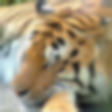

In [14]:
def example_transformed(transform: Callable[[torch.Tensor], torch.Tensor], image_id: int = 510, seed: int = 42) -> None:
    torch.manual_seed(seed)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[image_id]
    with torch.no_grad():
        img = transform(img)
    display_image_tensor(img)


def benchmark_transform(transform: v2.Transform) -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
    dataset = Subset(dataset, range(2500))
    dataloader = get_dataloader(dataset, batch_size=256, num_workers=0)
    for _image_batch, _label_batch in tqdm(dataloader):
        pass


example_transformed(v2.GaussianBlur(kernel_size=25, sigma=2.0), 513)

#### 1a: Blur
Implement a transformation that blurs the image (any method that makes the image visually smoother in all directions is fine).<br>
The transform should be parameterized by strength (from roughly 1 meaning no/minimal blurring to 100 meaning the image becomes unrecognizable to humans).<br>
For task 1a specifically, do not use any library beyond `torch.*` and python built-ins (in particular, do not use `torchvision`'s `GaussianBlur`).<br>

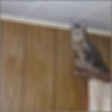

In [15]:
def blur(x: torch.Tensor, strength: int = 50) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    *B, C, H, W = x.shape
    ### BEGIN SOLUTION

    # some remapping from [1, 100] to [1, 10]
    kernel_size = max(1, strength // 10)

    # kernel idea taken from lecture slides
    kernel = torch.ones(C, 1, kernel_size, kernel_size) / (kernel_size * kernel_size)

    # apply convolution and ensure the same dimension
    x = F.conv2d(input=x, weight=kernel, groups=3, padding = "same")

    ### END SOLUTION
    return x


example_transformed(blur, 507)

In [16]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(blur)]))

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


#### 1b: Pixelize
Implement a transformation that averages blocks of `block_height x block_width` pixels, as in the example below.

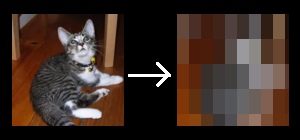

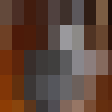

In [28]:
def pixelize(x: torch.Tensor, block_height: int = 8, block_width: int = 8) -> torch.Tensor:
    assert 1 <= block_height and 1 <= block_width, f"Expected ≥1, got {block_height=}, {block_width=}."
    ### BEGIN SOLUTION

    if x.dim() == 3:
       x = x.unsqueeze(0)

    B, C, H, W = x.shape
    # ceil mode to ensure that edges are counted in
    x = F.avg_pool2d(x, (block_height, block_width), ceil_mode = True)

    # interpolate by the given size, picture is gonna be slightly too big because ive put ceil_mode = True
    x = F.interpolate(x, scale_factor = (block_height, block_width))

    # cropping the image to the same dimension as input image
    # because I've included too many pixels
    x = x[:, :, :H, :W]

    if B == 1:
      x = x.squeeze(0)


    ### END SOLUTION
    return x


example_transformed(lambda x: pixelize(x, 25, 12), 510)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(pixelize)]))

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


#### 1c: Noise

Implement a transformation that adds noise (same on each channel, up to normalization constants) to an image.<br>
Any kind of noise like that is fine, but it should be parameterized by noise strength (from 1 unnoticeable to 100 unrecognizable) and grain size (roughly in pixels), as in the four examples below.<br>

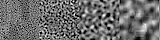

In [58]:
def noise(x: torch.Tensor, strength: int = 25, grain_size: int = 5) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    assert 1 <= grain_size <= 100, f"Expected 1 ≤ grain_size ≤ 100, got {grain_size}."
    ### BEGIN SOLUTION
    *B, C, H, W = x.shape

    # adjust grain_size range
    grain = H // grain_size * 30

    # generate random noise for one channe;
    noise = torch.randn((1, grain, grain))

    # interpolate to the proper size, bicubic because i like it visually the most
    noise = F.interpolate(noise[None], size=(H, W), mode='bicubic', align_corners=False)[0]

    # make sure we add same noise on every channel
    noise = noise.repeat(C, 1, 1)

    # add the noise to the image
    x += strength / 35 * noise

    # to get rid of weird blue beans
    x = torch.clamp(x, -1, 1)
    ### END SOLUTION
    return x

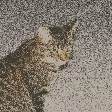

In [59]:
example_transformed(noise, 506)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(noise)]))

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


## Task 2: Comparing augmentations

Focus on the readability of the presented results.

Note: to use transforms defined in a notebook, you will have to call `evaluate()` with `use_workers=False`<br>
(this is because functions are pickled by reference, and those defined in a notebook cannot be imported by workers spawned by a dataloader;<br>
other workarounds include writing a Python module e.g. with `%%writefile file.py`, or using the `cloudpickle` package, but we prefer to keep it simple here).

#### Side note: lambdas in for loops

Since in this task it may be useful to use lots of lambdas (to change default parameters in your transformations),<br>
we would like to warn about one potential pitfall here.<br>

One 'gotcha' in Python is that 'for' variables (and similar blocks) are not scoped to the loop body,<br>
they continue with the value from the last iteration.

In [ ]:
def example() -> None:
    for i in range(3):
        for j in range(3):
            pass
        print(j)


example()

2
2
2


This is sometimes useful and mostly benign, but we may overlook using the wrong variable.

Another gotcha is that closures in Python (lambdas or def-s using variables from external scopes)<br>
are *late-binding*, meaning variables are captured by reference,<br>
so especially together with the previous gotcha, we get a probably-not-so-intuitive result:

In [ ]:
def example() -> None:
    funcs = [(lambda x: x + a) for a in range(3)]
    for f in funcs:
        print(f(0))


example()

2
2
2


Use `lambda x, a=a: f(x,a)` or `functools.partial(f, a=a)` to capture by value instead.

(A linter like [ruff](https://docs.astral.sh/ruff/) will warn you about both gotchas, by detecting e.g. [unused loop variables](https://docs.astral.sh/ruff/rules/unused-loop-control-variable/) and [loop variables used in closures](https://docs.astral.sh/ruff/rules/function-uses-loop-variable/), unfortunately there is no easy way to use them in Colab).

#### 2a: On vanilla model

Compare how `get_model()` performs on inputs from the `val` dataset, when transformed with your transformations (one at a time) or with `v2.GaussianBlur`, using different transform parameters.
(Use each transformation after `get_eval_transform()`, as in the benchmarks above.)

Plot the results. The total time taken by computations for this subtask must not exceed 10 minutes (on Colab GPU)<br>
(use fewer than 100 calls to evaluate(); if running on CPU, expect less than 40 minutes).<br>
Discuss the results in 2-4 sentences.

In [ ]:
### BEGIN SOLUTION

In [ ]:
# get model and set to eval
model = get_model(eval=True)

# initialize lists to store results
accuracy_pixel = []
parameters_pixel = []

# loop through different values of parametes
for block_height in range(2, 7, 2):
   for block_width in range(2, 7, 2):
      # for transformed data
      data = ImageFolder(MINI_IMAGENET_PATH / "val", transform=v2.Compose([get_eval_transform(), v2.Lambda(lambda img: pixelize(img, block_height, block_width))]))
      # upload new results
      accuracy_pixel.append(evaluate(model, data, use_workers = False))
      parameters_pixel.append([block_height, block_width])

eval: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, accuracy=24.2 %]


In [ ]:
# get model and set to eval
model = get_model(eval=True)

# initialize lists to store results
accuracy_blur = []
parameters_blur = []

# loop through different values of parametes
for strength in range(10, 101, 10):
    # for transformed data
    data = ImageFolder(MINI_IMAGENET_PATH / "val", transform=v2.Compose([get_eval_transform(), v2.Lambda(lambda img: blur(img, strength))]))
    # upload new results
    accuracy_blur.append(evaluate(model, data, use_workers = False))
    parameters_blur.append(strength)

eval: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it, accuracy=47.5 %]


In [ ]:
# get model and set to eval
model = get_model(eval=True)

# initialize lists to store results
accuracy_noise = []
parameters_noise = []

# loop through different values of parametes
for strength in range(10, 101, 30):
   for grain_size in range(10, 101, 30):
      # for transformed data
      data = ImageFolder(MINI_IMAGENET_PATH / "val", transform=v2.Compose([get_eval_transform(), v2.Lambda(lambda img: noise(img, strength, grain_size))]))
      # upload new results
      accuracy_noise.append(evaluate(model, data, use_workers = False))
      parameters_noise.append([strength, grain_size])

eval: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it, accuracy=12.4 %]


In [ ]:
# get model and set to eval
model = get_model(eval=True)

# initialize lists to store results
accuracy_Gblur = []
parameters_Gblur = []

# loop through different values of parametes
for kernel_size in range(3, 10, 2):
   for sigma in range(2, 9, 2):
      # for transformed data
      data = ImageFolder(MINI_IMAGENET_PATH / "val", transform=v2.Compose([get_eval_transform(), v2.GaussianBlur(kernel_size=kernel_size, sigma=sigma)]))
      # upload new results
      accuracy_Gblur.append(evaluate(model, data))
      parameters_Gblur.append([kernel_size, sigma])

eval: 100%|██████████| 4/4 [00:09<00:00,  2.49s/it, accuracy=56.1 %]


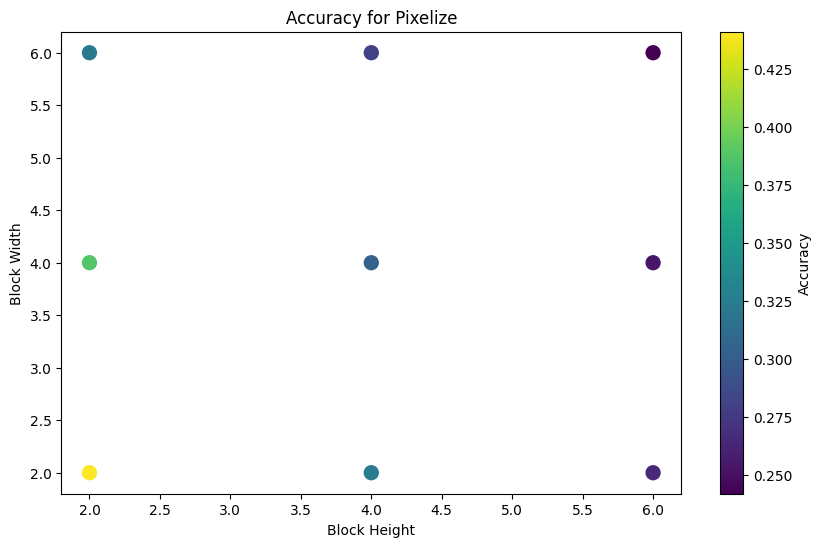

In [ ]:
import matplotlib.pyplot as plt

# Extract data
block_heights = [p[0] for p in parameters_pixel]
block_widths = [p[1] for p in parameters_pixel]

# Scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(block_heights, block_widths, c=accuracy_pixel, cmap='viridis', s=100)
plt.colorbar(scatter, label="Accuracy")
plt.xlabel("Block Height")
plt.ylabel("Block Width")
plt.title("Accuracy for Pixelize")
plt.show()

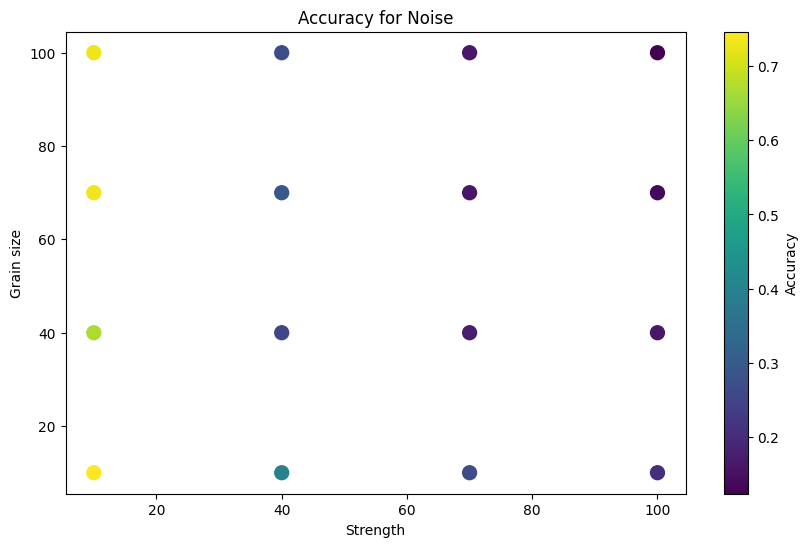

In [ ]:
# Extract data
strength = [p[0] for p in parameters_noise]
grain_size = [p[1] for p in parameters_noise]

# Scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(strength, grain_size, c=accuracy_noise, cmap='viridis', s=100)
plt.colorbar(scatter, label="Accuracy")
plt.xlabel("Strength")
plt.ylabel("Grain size")
plt.title("Accuracy for Noise")
plt.show()

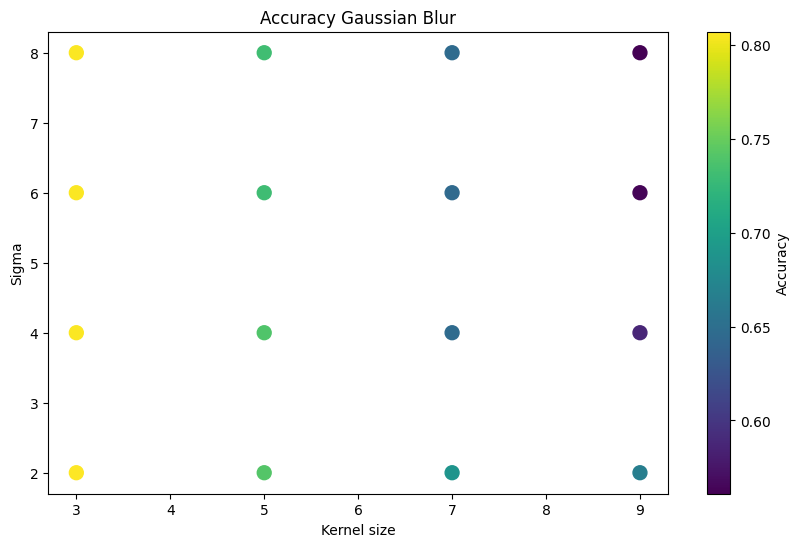

In [ ]:
# Extract data
kernel_size = [p[0] for p in parameters_Gblur]
sigma = [p[1] for p in parameters_Gblur]

# Scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(kernel_size, sigma, c=accuracy_Gblur, cmap='viridis', s=100)
plt.colorbar(scatter, label="Accuracy")
plt.xlabel("Kernel size")
plt.ylabel("Sigma")
plt.title("Accuracy Gaussian Blur")
plt.show()

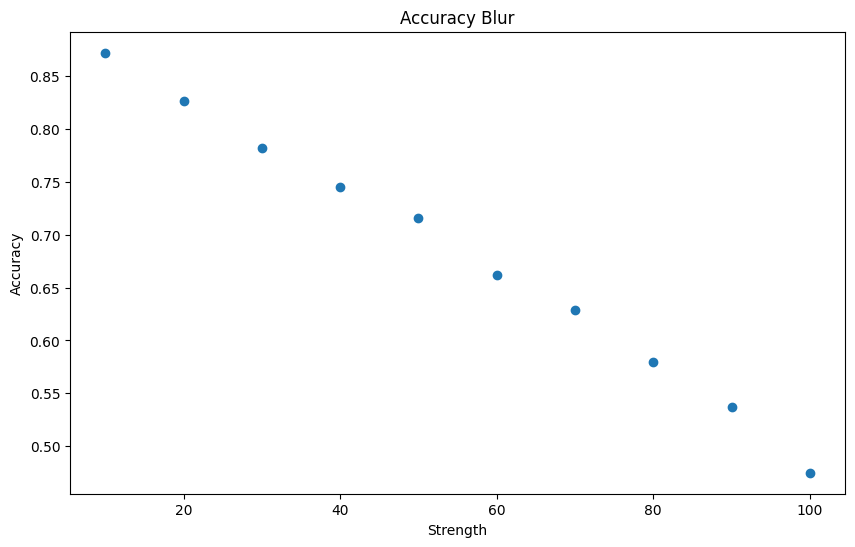

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(parameters_blur, accuracy_blur)
plt.xlabel("Strength")
plt.ylabel("Accuracy")
plt.title("Accuracy Blur")
plt.show()


**Discussion**

---


The fastest drop in accuracy is observed when using the pixelization function. Even with small parameter values, it becomes challenging, even for humans, to distinguish the contents of the image. The accuracy decreases significantly, falling to 30-40% when the height and width are set to just 2-3 pixels. Interestingly it seems to be working better with cases: (h, w) = (n, m) where n < m rather than (h, w) = (m, n) 🤔

What is more surprising is how well the model handles blurred images. It achieves over 45% accuracy on images that are entirely unrecognizable to humans (with 100% strength) and over 55% with kernel size equal to 9. A similar trend is seen with noisy images; the model performs relatively well even with a significant amount of noise. However, the grain size of the noise has an impact, with larger grains leading to significantly worse results (more visible with more strength).

---



In [ ]:
### END SOLUTION

#### 2b: Fine-tuning

Consider the following set of transformations: `{v2.Identity(), noise(strength=25, grain_size=3), v2.GaussianBlur(kernel_size=7, sigma=5)}`.

Compare how models fine-tuned for 3 epochs with each augmentation from that set<br>
(one at a time, using `Trainer(extra_augmentation=..., n_epochs=3)`, with `use_workers=False` if `noise` is used)<br>
performs on val with each augmentation from that set, and on the alt dataset with zero augmentations.<br>
We don't expect computations to take more than 20 minutes in total, for this subtask (on Colab GPU; CPU is too slow for fine-tuning, ~20min per epoch).

Present the `3 x 4` results in a table. Discuss the results in 1-2 sentences.

In [ ]:
### BEGIN SOLUTION
model_blur = get_model()
Trainer(extra_augmentation=v2.GaussianBlur(kernel_size = 7, sigma = 5), n_epochs=3).train(model = model_blur)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=67.8 %, lr=0.0002]


val=91.8 %	alt=51.0 %	


Train epoch   2: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s, train-acc=75.4 %, lr=0.000194]


val=91.3 %	alt=51.5 %	


Train epoch   3: 100%|██████████| 79/79 [01:14<00:00,  1.05it/s, train-acc=78.4 %, lr=0.000188]


val=92.0 %	alt=52.9 %	


{'val': [0.872, 0.918, 0.913, 0.92],
 'alt': [0.4342857142857143, 0.51, 0.5153571428571428, 0.5285714285714286]}

In [ ]:
model_id = get_model()
Trainer(extra_augmentation=v2.Identity(), n_epochs=3).train(model = model_id)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s, train-acc=77.1 %, lr=0.0002]


val=92.7 %	alt=49.9 %	


Train epoch   2: 100%|██████████| 79/79 [01:08<00:00,  1.15it/s, train-acc=83.6 %, lr=0.000194]


val=92.8 %	alt=48.4 %	


Train epoch   3: 100%|██████████| 79/79 [01:16<00:00,  1.03it/s, train-acc=85.0 %, lr=0.000188]


val=94.5 %	alt=49.5 %	


{'val': [0.872, 0.927, 0.928, 0.945],
 'alt': [0.4342857142857143,
  0.49857142857142855,
  0.4835714285714286,
  0.4953571428571429]}

In [ ]:
model_noise = get_model()
Trainer(extra_augmentation = partial(noise, strength=25, grain_size=3), n_epochs=3, use_workers = False).train(model = model_noise)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [04:07<00:00,  3.13s/it, train-acc=65.5 %, lr=0.0002]


val=92.4 %	alt=49.9 %	


Train epoch   2: 100%|██████████| 79/79 [03:59<00:00,  3.04s/it, train-acc=73.4 %, lr=0.000194]


val=92.4 %	alt=50.2 %	


Train epoch   3: 100%|██████████| 79/79 [03:53<00:00,  2.96s/it, train-acc=76.2 %, lr=0.000188]


val=92.0 %	alt=51.6 %	


{'val': [0.872, 0.924, 0.924, 0.92],
 'alt': [0.4342857142857143,
  0.4992857142857143,
  0.5017857142857143,
  0.5164285714285715]}

In [ ]:
dataset_blur = ImageFolder(MINI_IMAGENET_PATH / "val", transform=v2.Compose([get_eval_transform(), v2.GaussianBlur(kernel_size=7, sigma=5)]))
dataset_id = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
dataset_noise = ImageFolder(MINI_IMAGENET_PATH / "val", transform=v2.Compose([get_eval_transform(), partial(noise,strength=25, grain_size=3)]))

In [ ]:
datasets = [dataset_blur, dataset_id, dataset_noise, alt_test_dataset]

df = pd.DataFrame(columns=['GaussianBlur', 'Identity', 'Noise'], index=['GaussianBlur','Identity', 'Noise',  'Alt'])
results = []
# evaluate on differently trained models
for dataset in datasets:
    results.append({"GaussianBlur": evaluate(model_blur, dataset, use_workers = False),
               "Identity": evaluate(model_id, dataset, use_workers = False),
               "Noise": evaluate(model_noise, dataset, use_workers = False)})

df = pd.DataFrame(results, index=['GaussianBlur', 'Identity', 'Noise', 'Alt'])

eval: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it, accuracy=51.6 %]


In [ ]:
df

,GaussianBlur,Identity,Noise
GaussianBlur,0.804000,0.775000,0.778000
Identity,0.920000,0.945000,0.920000
Noise,0.662000,0.652000,0.793000
Alt,0.528571,0.495357,0.516429


**Discussion**

---


Columns show what they were trained on, rows what they were tested on.

The model performs best when trained on the same augmentations it is later tested on. On alt dataset it achieves the highest performance when trained on gaussian blur, worse when trained with noise, giving an accuracy of ~52.86% and 51.64% respectivly. The results are generally the best when evaluated on the identity transformation.


---



In [ ]:
### END SOLUTION

## Adversarial image modification with PGD

One method to improve robustness, other than augmentations, is to train on adversarial examples: images that are altered with small perturbations to fool the model.
Here's a typical implementation.

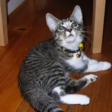

label=5 (cat)
Prediction: 5 (cat)


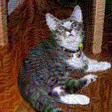

Prediction: 3 (bottle)


In [14]:
def adversarialPGD(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epsilon: float = 4 / 255,
    alpha: float = 2 / 255,
    n_iters: int = 1,
    random_init: bool = False,
) -> torch.Tensor:
    """
    Find an input xᵃᵈᵛ within x±ε pushing `model(xᵃᵈᵛ)` away from y (maximizing loss, unless alpha is negative).

    Uses 'Projective Gradient Descent' with learning rate `alpha` and `n_iters` iterations, as introduced in:
    Madry et al., "Towards Deep Learning Models Resistant to Adversarial Attacks", ICRL 2018
    https://openreview.net/forum?id=rJzIBfZAb

    Assumes x is 0..1-valued and keeps it in these bounds (i.e., it expects unnormalized images).
    """
    was_training = model.training
    model.eval()
    x = x.clone().detach()
    with torch.no_grad():
        x_min = torch.clamp(x - epsilon, min=0)
        x_max = torch.clamp(x + epsilon, max=1)

        if random_init:
            x = x + torch.empty_like(x).uniform_(-epsilon, epsilon)
            x.clamp_(x_min, x_max)

    for _ in range(n_iters):
        x.requires_grad = True
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)
        with torch.no_grad():
            x_grad = torch.autograd.grad(loss, x)[0]
            # We could also:
            #   loss.backward()
            #   x_grad = x.grad.detach()
            # but then we'd nedd to temporarily set requires_grad=False on all model parameters.
            x = x.detach() + alpha * x_grad.sign()
            x.clamp_(x_min, x_max)
            x = x.detach()

    if was_training:
        model.train()
    return x.requires_grad_(False)


def example(device="cuda") -> None:
    model = get_model(eval=True).to(device)

    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[510]
    display_image_tensor(img)
    print(f"{label=} ({dataset.classes[label]})")

    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    pred = model(img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")

    adv_img = normalize(adversarialPGD(model, unnormalize(img), label, epsilon=20 / 255, n_iters=100))
    display_image_tensor(adv_img[0])
    pred = model(adv_img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")


example()


## Task 3: AdvProp

Training on adversarial examples unfortunately tends to decrease accuracy on plain (unmodified) images a lot.<br>
The authors of [Adversarial Examples Improve Image Recognition](https://arxiv.org/abs/1911.09665) hypothesize that<br>
this is because adversarial examples (and the model activations they induce) follow different distributions.<br>
They propose addressing that by using auxilliary batch-norm-s for the adversarial images.

#### 3a: Implementation
Read the paper and implement this technique. Note that:
* Parameters (weights and biases of the affine transform applied after normalizing) should be the same for plain and adversarial images; only the running mean and variance (the buffers) are distinct.
* During evaluation, the plain batch-norms should be used.
* Add the two losses from plain and adversarial images using weights that sum up to one, specifically: `0.75 * plain_loss + 0.25 * adversarial_loss`.
* You should not need to alter this and other hyperparameters; use the defaults of `Trainer.__init__()` and `adversarialPGD` (they are different than suggested in the paper, but work better in our case).
* See `get_model()` for an example of how layers can be replaced. You can assume all batch-norms are instances of `torch.nn.BatchNorm2d` (with `affine=True`, `track_running_stats=True`, and non-null `momentum`).

I got really interested by this paper so I decided to implement two versions of this task. I think the second is more of what authors had in mind. The first is mostly to see how different the two methods would perform.

In [15]:
class AdvPropTrainer(Trainer):
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = "cuda",
        n_iters: int = 1,
        epsilon: float = 4 / 255,
        alpha: float = 2 / 255,
        adv_ratio: float = 0.25,
    ):
        super().__init__(
            lr=lr, weight_decay=weight_decay, batch_norm_momentum=batch_norm_momentum, n_epochs=n_epochs, device=device
        )
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.adv_ratio = adv_ratio

    ### BEGIN SOLUTION

        def train_epoch(
            self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
        ) -> None:
            model.train()
            n_correct = 0
            n_total = 0
            progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
            for image_batch, label_batch in progress_bar:
                image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

                #create adversarial images
                adversarial_batch = normalize(adversarialPGD(
                    model, unnormalize(image_batch), label_batch, epsilon=self.epsilon, alpha=self.alpha, n_iters=self.n_iters))

                optimizer.zero_grad()

                # set computing running statistics to True, we only want to update them for clean batch
                model.apply(lambda layer: setattr(layer, "track_running_stats", True) if isinstance(layer, torch.nn.modules.BatchNorm2d) else None)
                logits_plain = model(image_batch)
                loss_plain = torch.nn.CrossEntropyLoss()(logits_plain, label_batch)

                # set statistics to False to make sure they are not included in mean and variance used for evaluation
                model.apply(lambda layer: setattr(layer, "track_running_stats", False) if isinstance(layer, torch.nn.modules.BatchNorm2d) else None)
                logits_adv = model(adversarial_batch)
                loss_adv = torch.nnCrossEnropyLoss()(logits_adv, label_batch)


                # combine losses
                loss = self.adv_ratio * loss_adv + (1 - self.adv_ratio) * loss_plain

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    n_correct += (logits_plain.argmax(dim=1) == label_batch).sum().item()
                    n_total += len(label_batch)
                accuracy = n_correct / n_total
                progress_bar.set_postfix({"train-acc on clean": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})

    ### END SOLUTION

Approach that I think resembles method from paper

In [16]:
### BEGIN SOLUTION
class AdvPropaddBN(torch.nn.Module):
    def __init__(self, model: torch.nn.Module):
        self.model = model
        self.using_aux_bn = False

        # adding another batch norm to the model but without affine transform
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.BatchNorm2d):
                aux_bn = torch.nn.BatchNorm2d(
                    module.num_features,
                    eps=module.eps,
                    momentum=module.momentum,
                    # to use same beta and gamma for both BNs
                    affine= False,
                    track_running_stats=True,
                )
                setattr(self.model, f"{name}_aux", aux_bn)
                # the affine transforms will be taken from clean batch norms
                aux_bn.weight = module.weight
                aux_bn.bias = module.bias

    # tell which one will be used, False if no aux BN
    def if_aux_bn(self, use_aux: bool):
        self.using_aux_bn = use_aux

    # forward where we're deciding which BN to use, if using_aux_bn is True it will apply new BN
    def forward(self, x):
        def apply_bn_mode(m):
            if isinstance(m, torch.nn.BatchNorm2d):
                if self.using_aux_bn:
                    return getattr(self.model, f"{m._get_name()}_aux")
                return m
            return m

        return self.model.apply(apply_bn_mode)(x)
### END SOLUTION

In [17]:
class AdvPropTrainer_different(Trainer):
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = "cuda",
        n_iters: int = 1,
        epsilon: float = 4 / 255,
        alpha: float = 2 / 255,
        adv_ratio: float = 0.25,
    ):
        super().__init__(
            lr=lr, weight_decay=weight_decay, batch_norm_momentum=batch_norm_momentum, n_epochs=n_epochs, device=device
        )
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.adv_ratio = adv_ratio

    ### BEGIN SOLUTION
        # train is basically copied from Trainer
        def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
            # new, updated model
            model = AdvPropaddBN(model).to(self.device)

            if self.batch_norm_momentum is not None:
                # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
                for m in model.modules():
                    if isinstance(m, BATCH_NORM_TYPES):
                        m.momentum = self.batch_norm_momentum

            train_dataloader = self.get_train_dataloader()
            eval_dataloaders = self.get_eval_dataloaders()
            optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

            results = {k: [] for k in eval_dataloaders.keys()}
            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)

            for epoch in range(1, self.n_epochs + 1):
                self.train_epoch(model, train_dataloader, optimizer, epoch)
                lr_scheduler.step()

                # do evaluations on clean BN
                model.if_aux_bn(False)
                for k, v in self.do_evaluations(model, eval_dataloaders).items():
                    results[k].append(v)

            return results

        def train_epoch(
            self, model: AdvPropaddBN, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
        ) -> None:
            model.train()
            n_correct = 0
            n_total = 0
            progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
            for image_batch, label_batch in progress_bar:
                image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

                optimizer.zero_grad()

                # use clean BN on clean batch
                model.if_aux_bn(False)
                logits_clean = model(image_batch)
                loss_clean = torch.nn.CrossEntropyLoss()(logits_clean, label_batch)

                # use aux BN to generate PGD
                model.if_aux_bn(True)
                with torch.no_grad():
                    adversarial_batch = normalize(adversarialPGD(model, unnormalize(image_batch), label_batch,
                                                                 epsilon=self.epsilon, alpha=self.alpha, n_iters=self.n_iters))

                # use aux BN on adversarial batch
                logits_adv = model(adversarial_batch)
                loss_adv = torch.nnCrossEnropyLoss()(logits_adv, label_batch)

                # combine losses
                loss = self.adv_ratio * loss_adv + (1 - self.adv_ratio) * loss_clean

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    n_correct += (logits_clean.argmax(dim=1) == label_batch).sum().item()
                    n_total += len(label_batch)
                accuracy = n_correct / n_total
                progress_bar.set_postfix({"train-acc on clean": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})

    ### END SOLUTION

#### 3b: Evaluation

Compare Trainer and AdvPropTrainer (using default hyperparameters, 10 epochs, in particular).<br>
(One training with Trainer / AdvPropTrainer takes roughly 15 / 20 minutes on colab GPU, respectively).<br>
Discuss the results in 1-3 sentences (consider proposing what could be tested further, with more time).

In [ ]:
### BEGIN SOLUTION

In [ ]:
model = get_model()
Trainer().train(model = model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:31<00:00,  1.15s/it, train-acc=56.2 %, lr=0.0002]


val=90.3 %	alt=51.6 %	


Train epoch   2: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=66.1 %, lr=0.000194]


val=89.3 %	alt=52.8 %	


Train epoch   3: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it, train-acc=70.6 %, lr=0.000188]


val=90.3 %	alt=53.7 %	


Train epoch   4: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=73.0 %, lr=0.000183]


val=91.1 %	alt=53.2 %	


Train epoch   5: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=74.8 %, lr=0.000177]


val=90.8 %	alt=53.6 %	


Train epoch   6: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, train-acc=76.4 %, lr=0.000172]


val=90.4 %	alt=54.6 %	


Train epoch   7: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, train-acc=77.7 %, lr=0.000167]


val=92.6 %	alt=55.2 %	


Train epoch   8: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=78.4 %, lr=0.000162]


val=92.1 %	alt=53.2 %	


Train epoch   9: 100%|██████████| 79/79 [01:24<00:00,  1.06s/it, train-acc=79.0 %, lr=0.000157]


val=92.2 %	alt=53.5 %	


Train epoch  10: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, train-acc=79.7 %, lr=0.000152]


val=92.7 %	alt=53.1 %	


{'val': [0.872,
  0.903,
  0.893,
  0.903,
  0.911,
  0.908,
  0.904,
  0.926,
  0.921,
  0.922,
  0.927],
 'alt': [0.4342857142857143,
  0.5160714285714286,
  0.5278571428571428,
  0.5371428571428571,
  0.5317857142857143,
  0.5360714285714285,
  0.5464285714285714,
  0.5521428571428572,
  0.5321428571428571,
  0.535,
  0.5307142857142857]}

In [ ]:
model = get_model()
AdvPropTrainer_different().train(model = model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it, train-acc=56.3 %, lr=0.0002]


val=90.4 %	alt=51.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it, train-acc=66.1 %, lr=0.000194]


val=89.7 %	alt=51.9 %	


Train epoch   3: 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, train-acc=70.3 %, lr=0.000188]


val=90.4 %	alt=53.3 %	


Train epoch   4: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=73.0 %, lr=0.000183]


val=90.3 %	alt=54.0 %	


Train epoch   5: 100%|██████████| 79/79 [01:28<00:00,  1.12s/it, train-acc=75.6 %, lr=0.000177]


val=92.1 %	alt=54.1 %	


Train epoch   6: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=76.2 %, lr=0.000172]


val=92.8 %	alt=55.2 %	


Train epoch   7: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=77.8 %, lr=0.000167]


val=92.4 %	alt=54.2 %	


Train epoch   8: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, train-acc=78.6 %, lr=0.000162]


val=94.1 %	alt=55.5 %	


Train epoch   9: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=79.3 %, lr=0.000157]


val=94.1 %	alt=54.3 %	


Train epoch  10: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=79.8 %, lr=0.000152]


val=94.3 %	alt=53.8 %	


{'val': [0.872,
  0.904,
  0.897,
  0.904,
  0.903,
  0.921,
  0.928,
  0.924,
  0.941,
  0.941,
  0.943],
 'alt': [0.4342857142857143,
  0.515,
  0.5185714285714286,
  0.5328571428571428,
  0.54,
  0.5414285714285715,
  0.5517857142857143,
  0.5425,
  0.5546428571428571,
  0.5432142857142858,
  0.5375]}

In [ ]:
model = get_model()
AdvPropTrainer().train(model = model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it, train-acc=55.8 %, lr=0.0002]


val=90.2 %	alt=51.9 %	


Train epoch   2: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=66.2 %, lr=0.000194]


val=88.1 %	alt=51.7 %	


Train epoch   3: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=70.5 %, lr=0.000188]


val=89.5 %	alt=53.9 %	


Train epoch   4: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=73.1 %, lr=0.000183]


val=90.6 %	alt=54.6 %	


Train epoch   5: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=75.1 %, lr=0.000177]


val=90.8 %	alt=55.5 %	


Train epoch   6: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=76.7 %, lr=0.000172]


val=90.7 %	alt=55.7 %	


Train epoch   7: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=77.3 %, lr=0.000167]


val=91.9 %	alt=55.2 %	


Train epoch   8: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=78.3 %, lr=0.000162]


val=92.3 %	alt=56.3 %	


Train epoch   9: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=79.6 %, lr=0.000157]


val=93.1 %	alt=55.4 %	


Train epoch  10: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, train-acc=80.1 %, lr=0.000152]


val=93.5 %	alt=54.8 %	


{'val': [0.872,
  0.902,
  0.881,
  0.895,
  0.906,
  0.908,
  0.907,
  0.919,
  0.923,
  0.931,
  0.935],
 'alt': [0.4342857142857143,
  0.5189285714285714,
  0.5171428571428571,
  0.5385714285714286,
  0.5457142857142857,
  0.555,
  0.5571428571428572,
  0.5525,
  0.5632142857142857,
  0.5535714285714286,
  0.5475]}

In [ ]:
model = get_model()
AdvPropTrainer().train(model = model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:28<00:00,  1.13s/it, train-acc=55.9 %, lr=0.0002]


val=91.9 %	alt=51.6 %	


Train epoch   2: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=66.0 %, lr=0.000194]


val=89.4 %	alt=53.3 %	


Train epoch   3: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=69.8 %, lr=0.000188]


val=91.5 %	alt=54.6 %	


Train epoch   4: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=73.3 %, lr=0.000183]


val=90.2 %	alt=53.5 %	


Train epoch   5: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=75.5 %, lr=0.000177]


val=92.3 %	alt=54.8 %	


Train epoch   6: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=76.5 %, lr=0.000172]


val=92.3 %	alt=54.5 %	


Train epoch   7: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=76.9 %, lr=0.000167]


val=92.3 %	alt=55.4 %	


Train epoch   8: 100%|██████████| 79/79 [01:20<00:00,  1.01s/it, train-acc=78.0 %, lr=0.000162]


val=93.2 %	alt=55.7 %	


Train epoch   9: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=78.9 %, lr=0.000157]


val=94.2 %	alt=54.8 %	


Train epoch  10: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=79.6 %, lr=0.000152]


val=93.4 %	alt=54.4 %	


{'val': [0.872,
  0.919,
  0.894,
  0.915,
  0.902,
  0.923,
  0.923,
  0.923,
  0.932,
  0.942,
  0.934],
 'alt': [0.4342857142857143,
  0.5164285714285715,
  0.5328571428571428,
  0.5457142857142857,
  0.5346428571428572,
  0.5482142857142858,
  0.5446428571428571,
  0.5539285714285714,
  0.5567857142857143,
  0.5475,
  0.5442857142857143]}

In [ ]:
model = get_model()
AdvPropTrainer_different().train(model = model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=56.4 %, lr=0.0002]


val=90.3 %	alt=51.2 %	


Train epoch   2: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=66.6 %, lr=0.000194]


val=90.1 %	alt=51.7 %	


Train epoch   3: 100%|██████████| 79/79 [01:18<00:00,  1.00it/s, train-acc=71.0 %, lr=0.000188]


val=89.7 %	alt=52.9 %	


Train epoch   4: 100%|██████████| 79/79 [01:17<00:00,  1.01it/s, train-acc=73.9 %, lr=0.000183]


val=91.3 %	alt=54.0 %	


Train epoch   5: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=75.7 %, lr=0.000177]


val=91.2 %	alt=54.2 %	


Train epoch   6: 100%|██████████| 79/79 [01:19<00:00,  1.00s/it, train-acc=76.4 %, lr=0.000172]


val=91.6 %	alt=54.6 %	


Train epoch   7: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=77.0 %, lr=0.000167]


val=92.8 %	alt=54.8 %	


Train epoch   8: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=78.6 %, lr=0.000162]


val=93.3 %	alt=54.5 %	


Train epoch   9: 100%|██████████| 79/79 [01:20<00:00,  1.01s/it, train-acc=79.9 %, lr=0.000157]


val=93.7 %	alt=53.5 %	


Train epoch  10: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, train-acc=80.0 %, lr=0.000152]


val=94.2 %	alt=54.3 %	


{'val': [0.872,
  0.903,
  0.901,
  0.897,
  0.913,
  0.912,
  0.916,
  0.928,
  0.933,
  0.937,
  0.942],
 'alt': [0.4342857142857143,
  0.5125,
  0.5167857142857143,
  0.5289285714285714,
  0.5403571428571429,
  0.5421428571428571,
  0.5464285714285714,
  0.5482142857142858,
  0.545,
  0.535,
  0.5432142857142858]}

In [ ]:
model = get_model()
AdvPropTrainer().train(model = model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, train-acc=56.1 %, lr=0.0002]


val=89.8 %	alt=53.0 %	


Train epoch   2: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=66.2 %, lr=0.000194]


val=91.0 %	alt=54.4 %	


Train epoch   3: 100%|██████████| 79/79 [01:18<00:00,  1.01it/s, train-acc=70.4 %, lr=0.000188]


val=90.4 %	alt=54.4 %	


Train epoch   4: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=73.2 %, lr=0.000183]


val=91.3 %	alt=55.6 %	


Train epoch   5: 100%|██████████| 79/79 [01:20<00:00,  1.01s/it, train-acc=75.2 %, lr=0.000177]


val=92.3 %	alt=54.8 %	


Train epoch   6: 100%|██████████| 79/79 [01:37<00:00,  1.23s/it, train-acc=76.2 %, lr=0.000172]


val=92.4 %	alt=55.0 %	


Train epoch   7: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it, train-acc=77.7 %, lr=0.000167]


val=92.7 %	alt=55.5 %	


Train epoch   8: 100%|██████████| 79/79 [01:18<00:00,  1.00it/s, train-acc=78.5 %, lr=0.000162]


val=93.2 %	alt=55.6 %	


Train epoch   9: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=79.3 %, lr=0.000157]


val=93.3 %	alt=55.9 %	


Train epoch  10: 100%|██████████| 79/79 [01:18<00:00,  1.00it/s, train-acc=80.1 %, lr=0.000152]


val=93.8 %	alt=54.6 %	


{'val': [0.872,
  0.898,
  0.91,
  0.904,
  0.913,
  0.923,
  0.924,
  0.927,
  0.932,
  0.933,
  0.938],
 'alt': [0.4342857142857143,
  0.5303571428571429,
  0.5439285714285714,
  0.5442857142857143,
  0.5557142857142857,
  0.5482142857142858,
  0.5503571428571429,
  0.5546428571428571,
  0.5560714285714285,
  0.5589285714285714,
  0.5457142857142857]}

In [18]:
model = get_model()
AdvPropTrainer_different().train(model = model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:29<00:00,  1.13s/it, train-acc=55.5 %, lr=0.0002]


val=91.9 %	alt=52.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:24<00:00,  1.06s/it, train-acc=65.9 %, lr=0.000194]


val=90.3 %	alt=53.6 %	


Train epoch   3: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=70.6 %, lr=0.000188]


val=91.1 %	alt=53.5 %	


Train epoch   4: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, train-acc=73.5 %, lr=0.000183]


val=92.1 %	alt=55.0 %	


Train epoch   5: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, train-acc=75.5 %, lr=0.000177]


val=92.2 %	alt=54.9 %	


Train epoch   6: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=77.3 %, lr=0.000172]


val=93.4 %	alt=55.4 %	


Train epoch   7: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=77.1 %, lr=0.000167]


val=93.1 %	alt=54.6 %	


Train epoch   8: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=78.2 %, lr=0.000162]


val=94.6 %	alt=54.6 %	


Train epoch   9: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=78.9 %, lr=0.000157]


val=94.5 %	alt=54.4 %	


Train epoch  10: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, train-acc=79.7 %, lr=0.000152]


val=94.0 %	alt=54.8 %	


{'val': [0.872,
  0.919,
  0.903,
  0.911,
  0.921,
  0.922,
  0.934,
  0.931,
  0.946,
  0.945,
  0.94],
 'alt': [0.4342857142857143,
  0.5246428571428572,
  0.5357142857142857,
  0.535,
  0.5496428571428571,
  0.5492857142857143,
  0.5542857142857143,
  0.5464285714285714,
  0.5464285714285714,
  0.5435714285714286,
  0.5475]}

In [19]:
model = get_model()
AdvPropTrainer().train(model = model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:38<00:00,  1.25s/it, train-acc=56.5 %, lr=0.0002]


val=89.5 %	alt=53.0 %	


Train epoch   2: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=66.2 %, lr=0.000194]


val=89.6 %	alt=51.6 %	


Train epoch   3: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=70.7 %, lr=0.000188]


val=89.9 %	alt=51.4 %	


Train epoch   4: 100%|██████████| 79/79 [01:31<00:00,  1.15s/it, train-acc=73.4 %, lr=0.000183]


val=90.8 %	alt=53.3 %	


Train epoch   5: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=75.1 %, lr=0.000177]


val=91.0 %	alt=53.2 %	


Train epoch   6: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=76.8 %, lr=0.000172]


val=92.6 %	alt=54.6 %	


Train epoch   7: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=78.1 %, lr=0.000167]


val=92.8 %	alt=54.5 %	


Train epoch   8: 100%|██████████| 79/79 [01:30<00:00,  1.14s/it, train-acc=78.4 %, lr=0.000162]


val=94.1 %	alt=54.5 %	


Train epoch   9: 100%|██████████| 79/79 [01:29<00:00,  1.14s/it, train-acc=79.1 %, lr=0.000157]


val=93.4 %	alt=54.3 %	


Train epoch  10: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=80.1 %, lr=0.000152]


val=93.8 %	alt=54.4 %	


{'val': [0.872,
  0.895,
  0.896,
  0.899,
  0.908,
  0.91,
  0.926,
  0.928,
  0.941,
  0.934,
  0.938],
 'alt': [0.4342857142857143,
  0.5296428571428572,
  0.5157142857142857,
  0.5139285714285714,
  0.5328571428571428,
  0.5321428571428571,
  0.5460714285714285,
  0.5453571428571429,
  0.545,
  0.5432142857142858,
  0.5439285714285714]}

**Discussion**

---



Looking at the maximum accuracy over 10 epochs, AdvProp (both implementations) perform better than the vanilla model on the alternative dataset, with accuracy usually between 55.3% and 56.3%, it also seems to be more stable staying around this value for few epochs (instead of just once). This shows it might recognize shapes a bit better. It also does better on the clean validation dataset, where the vanilla model reaches a maximum accuracy of ~93%, while AdvProps achieve around ~94%, which is a noticeable improvement. I think some improvement would be to train it with additional augmentations, or maybe add multiple batchnorms for different image transformations.


---
I also wanted to emphasise differences between two implementatons because they're not technically the same and they perform a bit differently. It seems that second method achieves slightly higher accuracy on validation dataset (usually between 94.2% and 94.4 while first one around 93.7%) and slightly lower on alternative dataset (around 55%) than first one (55.7%-56%). It might be just noise but i find it very interesting and it could be investigated further with more time (and GPU).

---



In [ ]:
### END SOLUTION

## Task 4: SparseTopK

Another technique to improve robustness against style and pattern changes was proposed in
[Emergence of Shape Bias in CNNs through Activation Sparsity](https://openreview.net/forum?id=QzcZb3fWmW)
(you do not need to read the paper).
The idea is simple: in between some layers, enforce activation sparsity by zeroing out all but the top say 20% activations (by absolute value).
The hope is that the strong activations, which we keep, encode the more generalizable shape information.

More formally `SparseTopK`, for a fixed fraction $k$ like $20\%$, should be a module that for an input $x \in \mathbb{R}^{C \times H \times W}$ outputs:
$$ \begin{align*}
    x_{\text{out}}[c,h,w] &= x[c,h,w]\quad &&\text{ if } |x[c,h,w]| \geq \text{top-k-percentile}(x[c,:,:]) \\
                          &= 0 \quad &&\text{ otherwise}
\end{align*} $$

Your task is to:
* implement such a module below (for inputs of shape `(batch_size, C, H, W)`),
* run the example once (for 10 epochs),
* shortly discuss the result (one sentence).

In [ ]:
class SparseTopK(torch.nn.Module):
    def __init__(self, k: float):
        super().__init__()
        self.k = k
        assert 0 <= k <= 1, f"Expected 0 ≤ k ≤ 1, got {k}."

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### BEGIN SOLUTION
        *B, C, H, W = x.shape

        # # we want to save top 20% from every channel
        # # I tried doing it globally, it performs quite well, but its better (by around 4-5%) to do it this way
        x_flat = x.view(*B, C, -1)

        # Compute the top k activations for every channel
        k_percentile = torch.quantile(torch.abs(x_flat), 1 - self.k, dim=2, keepdim=True)

        # Zero out activations below the threshold
        mask = torch.abs(x_flat) >= k_percentile
        x_flat = x_flat * mask

        # back to the original shape
        x = x_flat.view(*B, C, H, W)

        ### END SOLUTION
        return x


def example_sparse() -> None:
    model = get_model()
    # The paper tests on ResNet18 and suggests inserting one SparseTopK(0.2) module after the second layer.
    # We'll do something similar for our model, EfficientNetB0.
    model.features[1][0].block.insert(3, SparseTopK(0.2))

    Trainer().train(model)


example_sparse()

val=71.8 %	alt=32.1 %	


Train epoch   1: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it, train-acc=40.6 %, lr=0.0002]


val=80.4 %	alt=47.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, train-acc=50.6 %, lr=0.000194]


val=82.8 %	alt=49.8 %	


Train epoch   3: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=57.0 %, lr=0.000188]


val=84.7 %	alt=52.0 %	


Train epoch   4: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=61.7 %, lr=0.000183]


val=85.6 %	alt=52.5 %	


Train epoch   5: 100%|██████████| 79/79 [01:19<00:00,  1.00s/it, train-acc=63.7 %, lr=0.000177]


val=85.5 %	alt=53.5 %	


Train epoch   6: 100%|██████████| 79/79 [01:20<00:00,  1.01s/it, train-acc=65.0 %, lr=0.000172]


val=85.2 %	alt=53.9 %	


Train epoch   7: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=66.6 %, lr=0.000167]


val=87.3 %	alt=54.8 %	


Train epoch   8: 100%|██████████| 79/79 [01:19<00:00,  1.00s/it, train-acc=68.3 %, lr=0.000162]


val=87.7 %	alt=54.9 %	


Train epoch   9: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=69.9 %, lr=0.000157]


val=88.7 %	alt=53.9 %	


Train epoch  10: 100%|██████████| 79/79 [01:19<00:00,  1.00s/it, train-acc=70.3 %, lr=0.000152]


val=88.5 %	alt=54.6 %	


`### BEGIN SOLUTION (discussion)`



---


It performs worse than AdvProp, although it consistently achieves an accuracy of around 54-55% on the alt dataset, which is a slight improvement over the vanilla model (that hits 55% but once or twice). However, it usually works worse on the validation dataset, with accuracy typically falling below 90%.


---


`### END SOLUTION`